<a href="https://colab.research.google.com/github/minhaz1172/Deep-Learning-with-PyTorch/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Steps**
# decided by reading VVG16 IN pytorch website
# 1.reshape data(images) from 1D(1,784) to 2D(28,28)
# 2.change dtype to np.uint8 for convert PIL from 2d
# 3.1D(1,28,28) to 3D(3,28,28)
# 4.tensor to PILImage
# 5.resize (3,256,256)
# 6.Center crop(3,224,224)
# 7.tensor(scale)=>(1,0)
# 8.normalize and std


In [1]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minhaz1172","key":"c20c43ca9e6e5be6fa69c912fab503c3"}'}

In [2]:

import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:

import os
import zipfile

# Make directory and move kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set proper permissions
!chmod 600 ~/.kaggle/kaggle.json

In [4]:

!pip install -q kaggle

In [5]:
!kaggle datasets download -d zalando-research/fashionmnist

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
  0% 0.00/68.8M [00:00<?, ?B/s]
100% 68.8M/68.8M [00:00<00:00, 1.30GB/s]


In [6]:
!unzip /content/fashionmnist.zip

Archive:  /content/fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [7]:

import numpy as np
import pandas as pd
import torch

In [8]:

# SET random seeds for reproducibility
torch.manual_seed(42)

In [9]:
df=pd.read_csv('/content/fashion-mnist_train.csv')
df.shape

(60000, 785)

In [10]:


df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


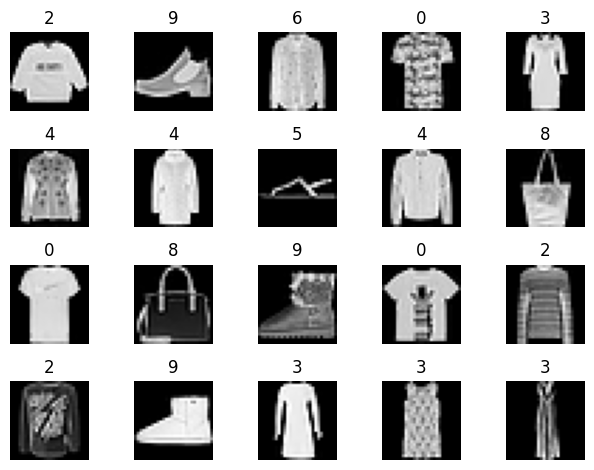

In [11]:

import matplotlib.pyplot as plt
for i in range(20):
  # first columns is label
  label=df.iloc[i,0]

  # remainging 784 values are pixel values of each image and there is 1 image = 1 row
  pixels=df.iloc[i,1:].values.reshape(28,28) # reshape to 28 by 28 images for recreating the original image. from pixel values
  # plot the image
  plt.subplot(4,5,i+1)
  plt.imshow(pixels,cmap='gray')
  plt.title(label)
  plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:

X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [13]:


from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Sources practiced in this project
[Source 1](https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

[Source 2](https://medium.com/@piyushkashyap045/transfer-learning-in-pytorch-fine-tuning-pretrained-models-for-custom-datasets-6737b03d6fa2)


[Source 3](https://debuggercafe.com/transfer-learning-with-pytorch/)

  [Soruce 4](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html)


In [14]:
from torchvision import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),                 # scale shorter side to 256px
    transforms.CenterCrop(224),             # crop the central 224×224 patch
    transforms.ToTensor(),                  # to tensor and scale [0,255]→[0.0,1.0]
    transforms.Normalize(                   # ImageNet channel-wise normalization
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# how stack works
# arr=np.array([(2,3),(4,5)])
 # arr.shape
 # arr=np.stack([arr]*3,axis=-1)
 # arr.shape

In [15]:
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        """
        features: NumPy array of shape (N, 28*28) or (N, 28, 28)
        labels:   List or array of length N
        transform: torchvision transforms to apply on each image
        """
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # Return the total number of samples
        return len(self.features)

    def __getitem__(self, index):
        # 1. Load raw image data and reshape to 28×28
        image = self.features[index]
        if image.ndim == 1:
            image = image.reshape(28, 28)

        # 2. Convert dtype from float or int to uint8 for PIL compatibility
        image = image.astype(np.uint8)

        # 3. Convert single-channel to three channels by stacking
        #    This makes shape (H, W, 3) so PIL recognizes it as RGB
        image = np.stack([image] * 3, axis=-1)

        # 4. Create a PIL image from the NumPy array
        image = Image.fromarray(image)

        # 5. Apply any torchvision transformations passed in
        if self.transform:
            image = self.transform(image)

        # 6. Retrieve corresponding label and cast to a LongTensor
        label = torch.tensor(self.labels[index], dtype=torch.long)

        return image, label


In [16]:
train_dataset=CustomDataset(X_train,y_train,transform=custom_transform)
test_dataset=CustomDataset(X_test,y_test,transform=custom_transform)

In [18]:
from torch.utils.data import DataLoader

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

# load the pretrain model vgg16

In [20]:
import torchvision.models as models
model = models.vgg16(pretrained=True)
# Print the model architecture
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 184MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
model.classifier # replace it with my own classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

# freeze the features part

In [23]:
for param in model.features.parameters():
  param.requires_grad=False

In [30]:
import torch.nn as nn
model.classifier=nn.Sequential(
    nn.Linear(25088,2048),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,10)
)

In [32]:
print(model) # see my own classifier

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
model=model.to(device)

In [34]:
learning_rate=0.0001 # during transfer learning learning rate must low

epochs=10

In [35]:
criterion=nn.CrossEntropyLoss()

# just update or optimize my own classifier neural network
optimizer=torch.optim.Adam(model.classifier.parameters() ,lr=learning_rate) # basically adam perform best

# training loop

In [39]:
# training loop

for epoch in range(epochs):
  train_loss=0.0

  for features,labels in train_loader:

  # move to gpu
   features,labels=features.to(device),labels.to(device)

  # forward pass
   outputs=model(features)

  # loss calculate
   loss=criterion(outputs,labels)

  # back pass

   optimizer.zero_grad()
   loss.backward()
   optimizer.step()

   train_loss=train_loss+loss.item()

   avg_loss=train_loss/len(train_loader)
   print(f"Loss:{avg_loss}")




Streaming output truncated to the last 5000 lines.
Loss:0.0444772521504201
Loss:0.044502070081575466
Loss:0.044559983280642576
Loss:0.04456834617427861
Loss:0.04469401557417586
Loss:0.0447414824681667
Loss:0.0447466997304
Loss:0.044767269272202
Loss:0.0448568729942975
Loss:0.044995194831086945
Loss:0.04500946507463232
Loss:0.04502124460771059
Loss:0.04512332053218658
Loss:0.04515391470476364
Loss:0.045285771553559846
Loss:0.04532724135105188
Loss:0.04537878444775318
Loss:0.04543197086437916
Loss:0.04548206785802419
Loss:0.045488960465881974
Loss:0.045523400305304676
Loss:0.045530099146533755
Loss:0.04578053761816894
Loss:0.04578577331624304
Loss:0.04584313416900113
Loss:0.04588971591911589
Loss:0.045965495481311035
Loss:0.04596815306336308
Loss:0.04600535044958815
Loss:0.04602640037875002
Loss:0.046110919069654
Loss:0.04621544340392575
Loss:0.0462795970205528
Loss:0.04630304236104712
Loss:0.04631058086905008
Loss:0.0463341201315634
Loss:0.04639837110741064
Loss:0.04644282572173203
Loss

# model evaluation

In [44]:
total=0
correct=0

with torch.no_grad():
 for features,labels in test_loader:
  features,labels=features.to(device),labels.to(device)

  y_pred=model(features)
  _,predicted=torch.max(y_pred.data,1)

  total=total+labels.shape[0]
  correct=correct+(predicted==labels).sum().item()

  accuracy=100*correct/total

  print(f"Accuracy:{accuracy:.2f}%")

Accuracy:93.75%
Accuracy:92.19%
Accuracy:89.58%
Accuracy:92.19%
Accuracy:91.88%
Accuracy:91.67%
Accuracy:92.41%
Accuracy:92.97%
Accuracy:93.75%
Accuracy:94.38%
Accuracy:94.60%
Accuracy:94.01%
Accuracy:94.23%
Accuracy:93.75%
Accuracy:93.12%
Accuracy:93.16%
Accuracy:93.20%
Accuracy:93.40%
Accuracy:93.26%
Accuracy:93.28%
Accuracy:92.86%
Accuracy:93.04%
Accuracy:92.66%
Accuracy:92.45%
Accuracy:92.50%
Accuracy:92.31%
Accuracy:92.13%
Accuracy:91.96%
Accuracy:91.70%
Accuracy:91.77%
Accuracy:91.83%
Accuracy:92.09%
Accuracy:92.14%
Accuracy:92.19%
Accuracy:92.23%
Accuracy:92.45%
Accuracy:92.48%
Accuracy:92.43%
Accuracy:92.55%
Accuracy:92.34%
Accuracy:92.38%
Accuracy:92.11%
Accuracy:92.22%
Accuracy:92.12%
Accuracy:92.15%
Accuracy:92.12%
Accuracy:92.22%
Accuracy:91.99%
Accuracy:92.09%
Accuracy:92.19%
Accuracy:92.16%
Accuracy:92.13%
Accuracy:92.10%
Accuracy:92.07%
Accuracy:92.05%
Accuracy:92.02%
Accuracy:91.94%
Accuracy:91.92%
Accuracy:91.95%
Accuracy:91.98%
Accuracy:91.96%
Accuracy:91.83%
Accuracy